# Improved DQN demoed with OpenAI Gym

- DQN Configuration:
    - Prioritized Experience Replay (PER)
    - Double DQN (implemented)
    - Dueling DQN (implemented)
    - Noisy Nets
- Network Architecture:
    - CNN * 3 + FC * 3
- Gym Environment:  `CartPoleV1`
    + Raw pixel input

In [1]:
import gym
import random 
import math
import os
import numpy as np
import matplotlib 
import matplotlib.pyplot as plt
from collections import namedtuple
from itertools import count
from PIL import Image

% matplotlib inline

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T


In [3]:
from IPython import display

In [4]:
# Create environment
env = gym.make('CartPole-v1').unwrapped

In [5]:
# Get device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print(device)

cuda


## Set Up Experience Replay Memory

+ `Transition` - a named tuple representing a single transition in our environment. It maps essentially maps (state, action) pairs to their (next_state, reward) result, with the state being the screen difference image as described later on.
+ `ReplayMemory` - a cyclic buffer of bounded size that holds the transitions observed recently. It also implements a `.sample()` method for selecting a random batch of transitions for training.

In [6]:
Transition = namedtuple('Transition', ('state', 'action', 'next_state', 'reward'))


In [7]:
class ReplayMemory(object):

    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = []
        self.position = 0
        
    def push(self, *args):
        """Saves a transition."""
        if len(self.memory) < self.capacity:
            self.memory.append(None)
        self.memory[self.position] = Transition(*args)
        self.position = (self.position + 1) % self.capacity
        
    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)
    
    def __len__(self):
        return len(self.memory)

## Q-Network

- Takes in 3 consecutive frames stacked together (#input channels = 4), and outputs a vector of size 2, representing $Q(s, left)$ and $Q(s, right)$ 
- Dueling DQN Implementation

In [166]:
# Dueling DQN Implementation
# 2 FC Layers to calculate Q(s, a):
#   Value stream calculates V(s)
#   Advantage stream calculates A(s, a) for each action a
# Aggregation layer: Q(s, a) = V(s) + (A(s, a) - mean value across actions(A(s, )))

class DQN(nn.Module):
    
    def __init__(self, h, w):
        super(DQN, self).__init__()
        
        # Number of Linear input connections depends on output of conv2d layers
        # and therefore the input image size, so comput it.
        def conv2d_output_size(size, kernel_size=3, stride=1):
            return (size - (kernel_size - 1) - 1) // stride + 1
        
        # Takes 3 consecutive images - #channel = 9
        self.conv1 = nn.Conv2d(9, 32, kernel_size=3, stride=1)
        self.bn1 = nn.BatchNorm2d(32)
        # Size Immediately after convolution
        conv1w = conv2d_output_size(w, kernel_size=3, stride=1)
        conv1h = conv2d_output_size(h, kernel_size=3, stride=1)
        # Size after max pooling
        conv1w = conv2d_output_size(conv1w, kernel_size=2, stride=2)
        conv1h = conv2d_output_size(conv1h, kernel_size=2, stride=2)
        
        self.conv2 = nn.Conv2d(32, 32, kernel_size=3, stride=1)
        self.bn2 = nn.BatchNorm2d(32)
        # Similarly
        conv2w = conv2d_output_size(conv1w, kernel_size=3, stride=1)
        conv2h = conv2d_output_size(conv1h, kernel_size=3, stride=1)
        conv2w = conv2d_output_size(conv2w, kernel_size=2, stride=2)
        conv2h = conv2d_output_size(conv2h, kernel_size=2, stride=2)
        
        self.conv3 = nn.Conv2d(32, 32, kernel_size=5, stride=2)
        self.bn3 = nn.BatchNorm2d(32)
        conv3w = conv2d_output_size(conv2w, kernel_size=5, stride=2)
        conv3h = conv2d_output_size(conv2h, kernel_size=5, stride=2)
        conv3w = conv2d_output_size(conv3w, kernel_size=2, stride=2)
        conv3h = conv2d_output_size(conv3h, kernel_size=2, stride=2)
        
        self.elu = nn.ELU()
        self.maxpool = nn.MaxPool2d(2)
        
        linear_input_size = conv3w * conv3h * 32
        
        # Dueling DQN: two streams 
        # Value stream: output dimension - 1
        self.VFC1 = nn.Linear(linear_input_size, 32)
        self.VFC2 = nn.Linear(32, 16)
        self.VFC3 = nn.Linear(16, 1)
        # Action stream: output dimension - 2
        self.AFC1 = nn.Linear(linear_input_size, 32)
        self.AFC2 = nn.Linear(32, 16)
        self.AFC3 = nn.Linear(16, 2)
        
    def forward(self, x):
        x = self.maxpool(self.bn1(self.elu(self.conv1(x))))
        x = self.maxpool(self.bn2(self.elu(self.conv2(x))))
        x = self.maxpool(self.bn3(self.elu(self.conv3(x))))
        x = torch.flatten(x, start_dim=1) # Flatten
        #print("x shape: ", x.shape)
        
        # Value stream: 
        v = self.elu(self.VFC1(x))
        v = self.elu(self.VFC2(v))
        v = self.elu(self.VFC3(v))
        #print("v shape:", v.shape)
        
        # Action sream:
        a = self.elu(self.AFC1(x))
        a = self.elu(self.AFC2(a))
        a = self.elu(self.AFC3(a))
        #print("a shape:", a.shape)
        
        # Aggregate:
        #print("a mean shape: ", a.mean(dim=-1).shape)
        #print("a substracted shape:", (a - a.mean(dim=-1, keepdim=True)).shape)
        q = v + (a - a.mean(dim=-1, keepdim=True))
        #print("q shape:", q.shape)
        
        return q
        

## Input Extraction


In [167]:
resize = T.Compose([T.ToPILImage(), T.Resize(50), T.ToTensor()])

In [168]:
def get_screen(env):
    screen = env.render(mode='rgb_array')
    # Cart is in the lower half, so strip off the top and bottom of the screen
    _, screen_height, screen_width = screen.shape
    screen = screen[int(screen_height * 0.25):int(screen_height * 0.55), :, :]
    # Transpose to size *C * H * W)
    screen.transpose((2, 0, 1))
    # Resize to add a batch dimension (B * C * H * W) and send to device
    return resize(screen).unsqueeze(0).to(device)
    
    

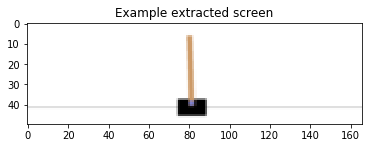

In [169]:
env.reset()
plt.figure()
plt.imshow((get_screen(env).cpu().squeeze(0).numpy() * 255).astype(dtype=np.uint8).transpose(1, 2, 0))
plt.title('Example extracted screen')
plt.show()

## Set Up the Model

In [170]:
batch_size = 128
gamma = 0.999
EPS_START = 0.9
EPS_END = 0.05
EPS_DECAY = 200
target_update = 10

In [171]:
init_screen = get_screen(env)
_, _, screen_height, screen_width = init_screen.shape

In [172]:
policy_net = DQN(screen_height, screen_width).to(device)
target_net = DQN(screen_height, screen_width).to(device)
target_net.load_state_dict(policy_net.state_dict())
target_net.eval()

DQN(
  (conv1): Conv2d(9, 32, kernel_size=(3, 3), stride=(1, 1))
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1))
  (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(32, 32, kernel_size=(5, 5), stride=(2, 2))
  (bn3): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (elu): ELU(alpha=1.0)
  (maxpool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (VFC1): Linear(in_features=576, out_features=32, bias=True)
  (VFC2): Linear(in_features=32, out_features=16, bias=True)
  (VFC3): Linear(in_features=16, out_features=1, bias=True)
  (AFC1): Linear(in_features=576, out_features=32, bias=True)
  (AFC2): Linear(in_features=32, out_features=16, bias=True)
  (AFC3): Linear(in_features=16, out_features=2, bias=True)
)

In [173]:
optimizer = optim.Adam(policy_net.parameters())
memory = ReplayMemory(10000)

steps_done = 0

In [174]:
def select_action(state, net):
    global steps_done
    sample = random.random()
    eps_threshold = EPS_END + (EPS_START - EPS_END) * math.exp(-1. * steps_done / EPS_DECAY) # Annealing
    steps_done += 1
    if sample > eps_threshold:
        with torch.no_grad():
            # t.max(1) will return largest value for column of each row. 
            # second column on max result is index of where max element was found, 
            # so we pick action with the larger expected reward
            
            # DOUBLE DQN implementation:
            #. we use the online policy net to greedily select the action 
            #. and the target net to estimate the Q-value
            #. so NO CHANGE HERE
            return policy_net(state).max(1)[1].view(1, 1)
    else:
        return torch.tensor([[random.randrange(2)]], device=device, dtype=torch.long)
    

In [175]:
def select_action_for_evaluation(state, net):
    with torch.no_grad():
        return policy_net(state).max(1)[1].view(1, 1)

In [176]:
def plot_durations():
    display.clear_output(wait=True)
    plt.figure(2)
    plt.clf()
    durations_t = torch.tensor(episode_durations, dtype=torch.float)
    plt.title('Training...')
    plt.xlabel('Episode')
    plt.ylabel('Duration')
    plt.plot(durations_t.numpy())
    # Take 100 episode averages and plot them too
    if len(durations_t) > 100:
        means = durations_t.unfold(0, 100, 1).mean(1).view(-1)
        means = torch.cat((torch.zeros(99), means))
        plt.plot(means.numpy())
    plt.show()
    
    

## Training 

In [177]:
def optimize_model(batch_size, memory, policy_net, target_net):
    if len(memory) < batch_size:
        return
    transitions = memory.sample(batch_size)
    # Transpose the batch. This converts batch-array of Transitions to Transition of batch-arrays
    batch = Transition(*zip(*transitions))
    
    # Compute a mask of non-final states and concatenate the batch elements 
    # (a final state would've been the one after which simulation ended)
    non_final_mask = torch.tensor(tuple(map(lambda s : s is not None, batch.next_state)), device=device, dtype=torch.uint8)
    non_final_next_states = torch.cat([s for s in batch.next_state if s is not None])
    
    state_batch = torch.cat(batch.state)
    action_batch = torch.cat(batch.action)
    reward_batch = torch.cat(batch.reward)
    
    # Compute Q(s_t, a) - the model computes Q(s_t), then we select the columns of actions taken.
    # These are the actions which would've been taken for each batch state according to policy_net
    state_action_values = policy_net(state_batch).gather(1, action_batch)
    
    # Compute V(s_{t+1}) for all next states
    # Expected values of actions for non_final_next_states are computed
    # This is merged based on the mask, such that we'll have either the expected state value or 0 
    # in case the state was final
    
    # DOUBLE DQN implementation:
    #. we use the online policy net to greedily select the action 
    #. and the target net to estimate the Q-value
    next_state_values = torch.zeros(batch_size, device=device)
    next_action_policynet_decisions = policy_net(non_final_next_states).max(1)[1]
    non_final_next_state_targetnet_values = target_net(non_final_next_states) \
        .gather(1, next_action_policynet_decisions.view(-1, 1).repeat(1, 2))[:, 0]
    next_state_values[non_final_mask] = non_final_next_state_targetnet_values.detach()
    
    # Compute the expected Q values
    expected_state_action_values = (next_state_values * gamma) + reward_batch
    
    # Compute Huber loss
    loss = F.smooth_l1_loss(state_action_values, expected_state_action_values.unsqueeze(1))
    
    # Optimize the model
    optimizer.zero_grad()
    loss.backward()
    
    for param in policy_net.parameters():
        param.grad.data.clamp_(-1, 1)
    optimizer.step()
    

In [178]:
def save_checkpoint(file_dir, policy_net, target_net, optimizer, i_episode, episode_durations):
    save_dict = {"policy_net": policy_net.state_dict(),
                 "target_net": target_net.state_dict(),
                 "optimizer": optimizer.state_dict(),
                 "i_episode": i_episode,
                 "episode_durations": episode_durations}
    # Create the directory if not exist
    if not os.path.isdir(file_dir):
        os.makedirs(file_dir)
    torch.save(save_dict, os.path.join(file_dir, "ckpt_eps%d.pt" % i_episode))
    

In [179]:
def load_checkpoint(file_dir, i_episode):
    checkpoint = torch.load(os.path.join(file_dir, "ckpt_eps%d.pt" % i_episode))
    
    policy_net = DQN(screen_height, screen_width).to(device)
    policy_net.load_state_dict(checkpoint["policy_net"])
    policy_net.train()
    
    target_net = DQN(screen_height, screen_width).to(device)
    target_net.load_state_dict(checkpoint["target_net"])
    target_net.eval()
    
    optimizer = optim.Adam(policy_net.parameters())
    optimizer.load_state_dict(checkpoint["optimizer"])
    
    i_episode = checkpoint["i_episode"]
    episode_durations = checkpoint["episode_durations"]
    
    return policy_net, target_net, optimizer, i_episode, episode_durations
    

In [180]:
num_episodes = 10000
ckpt_dir = "DDDQN_CartPoleV1_pixel_checkpoints/"
save_ckpt_interval = 100



In [183]:
episode_durations = []
i_episode = 6000

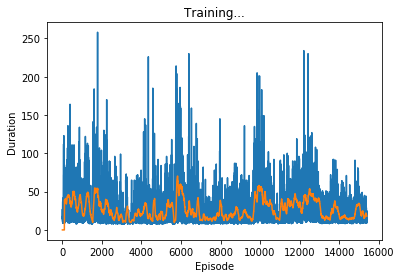

Episode: 15402 Cumulative Rewards: 11


KeyboardInterrupt: 

In [184]:
policy_net.train()

while True:
    # Every save_ckpt_interval, Check if there is any checkpoint. 
    # If there is, load checkpoint and continue training
    # Need to specify the i_episode of the checkpoint intended to load
    if i_episode % save_ckpt_interval == 0 and os.path.isfile(os.path.join(ckpt_dir, "ckpt_eps%d.pt" % i_episode)):
        policy_net, target_net, optimizer, i_episode, episode_durations = load_checkpoint(ckpt_dir, i_episode)
    
    # Initialize the environment and state
    env.reset()
    screen_0 = get_screen(env)
    screen_1 = get_screen(env)
    screen_2 = get_screen(env)
    state = torch.cat([screen_0, screen_1, screen_2], dim=1)
    
    for t in count():
        # Select and perform an action
        action = select_action(state, policy_net)
        _, reward, done, _ = env.step(action.item())
        reward = torch.tensor([reward], device=device)
        
        # Observe new state
        screen_0 = screen_1
        screen_1 = screen_2
        screen_2 = get_screen(env)
        
        if not done:
            next_state = torch.cat([screen_0, screen_1, screen_2], dim=1)
        else:
            next_state = None
            
        # Store the transition in memory
        memory.push(state, action, next_state, reward)
        
        # Move to the next state
        state = next_state
        
        # Perform one step of the optimization (on the target network)
        optimize_model(batch_size, memory, policy_net, target_net)
        if done:
            # Save and print episode stats
            episode_durations.append(t + 1)
            plot_durations()
            print("Episode: %d Cumulative Rewards: %d" % (i_episode + 1, t + 1))
            break
            
    # Update the target network, copying all weights and biases in DQN
    if i_episode % target_update == 0:
        target_net.load_state_dict(policy_net.state_dict())
        
    # Every save_ckpt_interval, save a checkpoint according to current i_episode.
    # Note that we use i_episode + 1
    if (i_episode + 1) % save_ckpt_interval == 0:
        save_checkpoint(ckpt_dir, policy_net, target_net, optimizer, i_episode + 1, episode_durations)
    
    
    i_episode += 1
        
print("Complete")
env.render()
env.close()
plt.ioff()
plt.show()
    

## Evaluation / Test Run

In [ ]:
env.reset()
policy_net.eval()
screen_0 = get_screen(env)
screen_1 = get_screen(env)
screen_2 = get_screen(env)
state = torch.cat([screen_0, screen_1, screen_2], dim=1)

for t in count():
    # Select and perform an action
    action = select_action(state, policy_net)
    _, reward, done, _ = env.step(action.item())
    reward = torch.tensor([reward], device=device)

    # Observe new state
    screen_0 = screen_1
    screen_1 = screen_2
    screen_2 = get_screen(env)

    if not done:
        next_state = torch.cat([screen_0, screen_1, screen_2], dim=1)
    else:
        next_state = None

    # Store the transition in memory
    memory.push(state, action, next_state, reward)

    # Move to the next state
    state = next_state

    if done:
        print("Cumulative Rewards: %d" % (t + 1))
        break